In [1]:
from __future__ import print_function, absolute_import
from WISE_tools import *
import FATS, pandas as pd, numpy as np
from multiprocessing import Pool
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import fitting
from scipy.odr import *
from sklearn.metrics import r2_score

In [2]:
from pebble import ProcessPool
from concurrent.futures import TimeoutError

In [3]:
unique_names = parse_source_names('../data/bright_blue_lightcurves/data/')

In [4]:
def KDE_fit(x,y):
    """
    A function that performs a gaussian KDE on x/y data, then fits the result with a sum
    of 2 2D gaussians
    
    Parameters
    ----------
    x : array-like
        x data
    y : array-like
        y data
        
    Returns
    -------
    KDE_bandwidth : float
        Cross-validated kernel bandwidth
    KD_fit_sqresid : float
        The mean squared residual (fit - KDE)^2
    amp_0 : float
        amplitude of largest gaussian
    xmean_0 : float
        x mean of largest gaussian
    ymean_0 : float
        y mean of largest gaussian
    major_std_0 : float
        Standard deviation along major axis of largest gaussian
    theta_0 : float
        Radians between positive X-axis and the major axis of the largest gaussian
    ecc_0 : float
        Eccentricity of an ellipse, taken at an arbitrary height of the largest gaussian
    amp_1 : float
        amplitude of smallest gaussian
    xmean_1 : float
        x mean of smallest gaussian
    ymean_1 : float
        y mean of smallest gaussian
    major_std_1 : float
        Standard deviation along major axis of smallest gaussian
    theta_1 : float
        Radians between positive X-axis and the major axis of the largest gaussian
    ecc_1 : float
        Eccentricity of an ellipse, taken at an arbitrary height of the smallest gaussian
    """
    
    data = np.vstack([x, y]).T
    #Grid search for best KDE bandwidth
    params = {'bandwidth': np.linspace(np.min(np.diff(y)),np.max(np.diff(y)),100)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)
    
    KDE_bandwidth = grid.best_estimator_.bandwidth
    
    kde = grid.best_estimator_
    X, Y = np.meshgrid(np.linspace(np.min(x),np.max(x),100), np.linspace(np.min(y),np.max(y),100))

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #compute the KDE on a 100x100 grid of points
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
    
    #fit KDE estimation with 2 Gaussian model
    g2D_init1 = Gaussian2D(amplitude=np.max(Z), x_mean=X[np.unravel_index(np.argmax(Z),Z.shape)], y_mean=Y[np.unravel_index(np.argmax(Z),Z.shape)], x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})
    g2D_init2 = Gaussian2D(amplitude=np.median(Z), x_mean=np.median(x), y_mean=np.median(y), x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})
    g2D_init = g2D_init1 + g2D_init2

    fitter = fitting.LevMarLSQFitter()
    
    g2D = fitter(g2D_init, X, Y, Z)
    
    KD_fit_sqresid = np.mean(np.power(Z-g2D(X,Y),2.0))
    
    #Sort by largest and smallest amplitude gaussian
    i_large = np.argmax([g2D.amplitude_0,g2D.amplitude_1])
    i_small = np.argmin([g2D.amplitude_0,g2D.amplitude_1])
    g2D_large = g2D[i_large]
    g2D_small = g2D[i_small]
    
    amp_0 = g2D_large.amplitude.value
    amp_1 = g2D_small.amplitude.value
    
    xmean_0 = g2D_large.x_mean.value
    xmean_1 = g2D_small.x_mean.value
    
    ymean_0 = g2D_large.y_mean.value
    ymean_1 = g2D_small.y_mean.value
    
    if g2D_large.x_stddev >= g2D_large.y_stddev:
        
        major_std_0 = g2D_large.x_stddev.value
        theta_0 = g2D_large.theta.value
        ecc_0 = np.sqrt(1.0 - (g2D_large.y_stddev.value/g2D_large.x_stddev.value)**2.0)
    
    else:
        
        major_std_0 = g2D_large.y_stddev.value
        
        if g2D_large.theta <= np.pi/2:
            theta_0 = np.pi/2 + g2D_large.theta.value
            
        elif g2D_large.theta > np.pi/2:
            theta_0 = g2D_large.theta.value - np.pi/2
             
        ecc_0 = np.sqrt(1.0 - (g2D_large.x_stddev.value/g2D_large.y_stddev.value)**2.0)
        
    if g2D_small.x_stddev >= g2D_small.y_stddev:
        
        major_std_1 = g2D_small.x_stddev.value
        theta_1 = g2D_small.theta.value
        ecc_1 = np.sqrt(1.0 - (g2D_small.y_stddev.value/g2D_small.x_stddev.value)**2.0)
    
    else:
        
        major_std_1 = g2D_small.y_stddev.value
        
        if g2D_small.theta <= np.pi/2:
            theta_1 = np.pi/2 + g2D_small.theta.value
            
        elif g2D_small.theta > np.pi/2:
            theta_1 = g2D_small.theta.value - np.pi/2
             
        ecc_1 = np.sqrt(1.0 - (g2D_small.x_stddev.value/g2D_small.y_stddev.value)**2.0)
        
    return (KDE_bandwidth, KD_fit_sqresid, amp_0, xmean_0, ymean_0, major_std_0, theta_0,
            ecc_0, amp_1, xmean_1, ymean_1, major_std_1, theta_1, ecc_1)

In [5]:
def line(p, x):
    m, b = p
    return m*x + b

In [6]:
def linear_CMD_fit(x,y,xerr,yerr):
    """
    Does a linear fit to CMD data where x is color and y is amplitude, returning some fit 
    statistics
    
    Parameters
    ----------
    x : array-like
        color
    y : array-like
        magnitude
    xerr : array-like
        color errors
    yerr : array-like
        magnitude errors
    
    Returns
    -------
    slope : float
        slope of best-fit line
    r_squared : float
        Correlation coefficient (R^2)
    """
    
    data = RealData(x, y, sx=xerr, sy=yerr)
    
    mod = Model(line)
    
    odr = ODR(data, mod, beta0=[-0.1, np.mean(y)])
    out = odr.run()
    
    slope = out.beta[0]
    
    r_squared = r2_score(y, line(out.beta, x))
    
    return slope, r_squared

(10.1, 9.0)

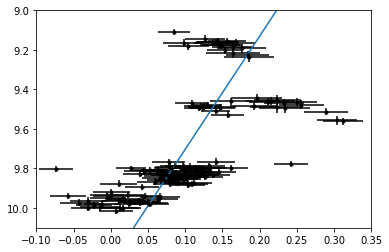

In [312]:
x = df['w1mpro'].values - df['w2mpro'].values
xerr = np.sqrt(df['w1sigmpro'].values*df['w1sigmpro'].values + df['w2sigmpro'].values*df['w2sigmpro'].values)

y = df['w1mpro'].values
yerr = df['w1sigmpro'].values
s,r,b = linear_CMD_fit(x, y, xerr, yerr)
plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
xtest = np.linspace(np.min(x),np.max(x),100)
plt.plot(xtest,line(b,xtest))
plt.xlim(-0.1,0.35)
plt.ylim(10.1,9.0)

In [7]:
def get_features(name):
    """
    A function that is given a name, and then outputs all 68 features (plus the name)
    in a handy pandas dataframe.
    
    Parameter
    ---------
    Name : str
        WISE source name output by WISE_tools.parse_source_names
        
    Returns
    -------
    features : `~pandas.DataFrame`
        Dataframe of all 68 features, plus a column for the name.
    """
    
    df = get_lightcurve(name, '../data/bright_blue_lightcurves/data/')
    lc = np.array([df['w1mpro'].values,df['mjd'].values,df['w1sigmpro'].values,
                df['w2mpro'].values,df['w1mpro'].values,df['w2mpro'].values,
                df['mjd'].values,df['w1sigmpro'].values,df['w2sigmpro'].values])
    
    a = FATS.FeatureSpace(Data=['magnitude', 'time', 'error', 'magnitude2', 'error2'],
                           excludeList=[])
    a.calculateFeature(lc)
    result = a.result('dict')
    
    #Now let's add our own features
    #KDE in CMD space
    x = df['w1mpro'].values - df['w2mpro'].values
    xerr = np.sqrt(df['w1sigmpro'].values*df['w1sigmpro'].values + df['w2sigmpro'].values*df['w2sigmpro'].values)
    
    y = df['w1mpro'].values
    yerr = df['w1sigmpro'].values
    
    (KDE_bandwidth, KD_fit_sqresid, amp_0, xmean_0, ymean_0, major_std_0, theta_0,
            ecc_0, amp_1, xmean_1, ymean_1, major_std_1, theta_1, ecc_1) = KDE_fit(x,y)
    
    result['KDE_bandwidth'] = KDE_bandwidth
    result['KD_fit_sqresid'] = KD_fit_sqresid
    result['KD_amp_0'] = amp_0
    result['KD_xmean_0'] = xmean_0
    result['KD_ymean_0'] = ymean_0
    result['KD_major_std_0'] = major_std_0
    result['KD_theta_0'] = theta_0
    result['KD_ecc_0'] = ecc_0
    result['KD_amp_1'] = amp_1
    result['KD_xmean_1'] = xmean_1
    result['KD_ymean_1'] = ymean_1
    result['KD_major_std_1'] = major_std_1
    result['KD_theta_1'] = theta_1
    result['KD_ecc_1'] = ecc_1
    
    slope, r_squared = linear_CMD_fit(x, y, xerr, yerr)
    result['CMD_slope'] = slope
    result['CMD_r_squared'] = r_squared
    
    result['Name'] = name
    
    return pd.DataFrame(data=np.array(result.values()).reshape(1,len(result.values())), 
                        columns=result.keys())

In [12]:
%%time
results = []

with ProcessPool(max_workers=4) as pool:
    future = pool.map(get_features, unique_names[:10], timeout=15)

    iterator = future.result()

    # iterate over all results, if a computation timed out
    # print it and continue to the next result
    while True:
        try:
            result = next(iterator)
            results.append(result)
        except StopIteration:
            break  
        except TimeoutError as error:
            print("function took longer than {0} seconds".format(error.args[1]))

print(results)
out = pd.concat(results)

"""p = Pool(8)
dfs = p.map(get_features,np.tile(unique_names,8))
out = pd.concat(dfs)
out.to_csv('test_features.csv')"""

/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:927: RuntimeWarning: overflow encountered in exp
  a_new = np.exp(-(t[i] - t[i - 1]) / tau)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:932: RuntimeWarning: invalid value encountered in add
  (x_ast[i - 1] - x_hat[i - 1]))
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:931: RuntimeWarning: invalid value encountered in divide
  (a_new * Omega[i - 1] / (Omega[i - 1] + error_vars[i - 1])) *
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FAT

function took longer than 15 seconds
function took longer than 15 seconds
function took longer than 15 seconds
function took longer than 15 seconds


/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:927: RuntimeWarning: overflow encountered in exp
  a_new = np.exp(-(t[i] - t[i - 1]) / tau)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:932: RuntimeWarning: invalid value encountered in add
  (x_ast[i - 1] - x_hat[i - 1]))
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:931: RuntimeWarning: invalid value encountered in divide
  (a_new * Omega[i - 1] / (Omega[i - 1] + error_vars[i - 1])) *
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/FATS/FeatureFunctionLib.py:936: RuntimeWarning: invalid value encountered in divide
  (1 - (Omega[i - 1] / (Omega[i - 1] + error_vars[i - 1]))))
/Users/carina/anaconda/envs/iraf27/lib/p

function took longer than 15 seconds


[          Psi_eta Q31_color PercentAmplitude       MaxSlope   SmallKurtosis  \
0  0.303689464901     0.057  0.0144273322712  722.532001209  -1.00691561479   

    KD_major_std_0     KD_theta_0  KD_fit_sqresid       StetsonJ  \
0  0.0747464429946  2.10415505411  0.113254330267  2.30013832274   

       Eta_color     ...     Freq1_harmonics_rel_phase_3   PairSlopeTrend  \
0  1411787560.07     ...                  0.947930965322  -0.233333333333   

         CAR_sigma Autocor_length StructureFunction_index_31 MedianAbsDev  \
0  0.0180213104795           32.0              2.28157539544        0.044   

    Gskew FluxPercentileRatioMid80      PeriodLS StetsonK_AC  
0  -0.053           0.857923497268  16487.264348         1.0  

[1 rows x 85 columns],            Psi_eta Q31_color PercentAmplitude      MaxSlope   SmallKurtosis  \
0  0.0712302889282      0.16  0.0586058519793  746.21004559  -1.60575366508   

   KD_major_std_0     KD_theta_0 KD_fit_sqresid       StetsonJ      Eta_color  \
0  

In [14]:
out['Name']

0    J000305.74+632002.1
0    J000422.92+574931.2
0    J000557.59+633701.3
0    J000633.81+632634.2
0    J000636.56+434228.2
Name: Name, dtype: object

In [280]:

x = df['w1mpro'] - df['w2mpro']
y = df['w1mpro']
data = np.vstack([x, y]).T

params = {'bandwidth': np.linspace(np.min(np.diff(y)),np.max(np.diff(y)),100)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

best bandwidth: 0.117666666667


In [7]:
lens = []
for name in unique_names:
    df = get_lightcurve(name,'../data/bright_blue_lightcurves/data/')
    lens.append(len(df))
lens = np.array(lens)

In [46]:
longest = unique_names[lens == max(lens)]

In [49]:
df = get_lightcurve(longest[0],'../data/bright_blue_lightcurves/data/')

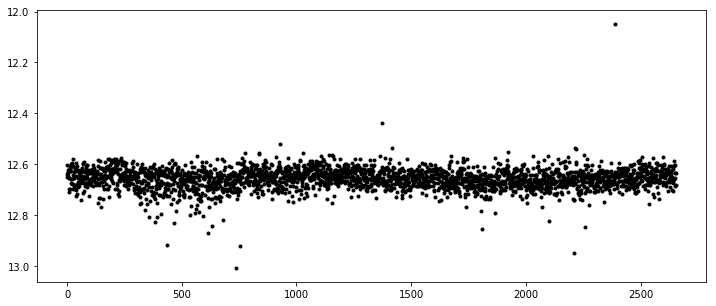

In [59]:
plt.figure(figsize=(12,5))
plt.scatter(range(len(df)),df['w1mpro'],marker='.',c='k')
plt.gca().invert_yaxis()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

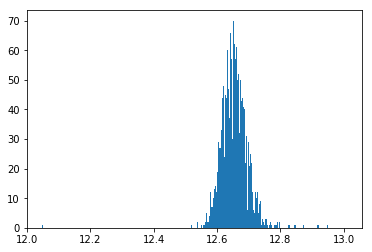

In [55]:
plt.hist(df['w1mpro'],bins=500)

In [56]:
%%time

long_feat = get_features(longest[0])

CPU times: user 5min 2s, sys: 7.76 s, total: 5min 10s
Wall time: 5min 14s


(0, 500)

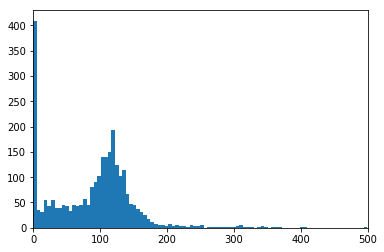

In [8]:
plt.hist(lens,bins=500);
plt.xlim(0,500)

In [27]:
test_lens = (lens >= 21)&(lens <= 22)
test_names = unique_names[test_lens]
name_lens = lens[test_lens]

In [28]:
len(test_names)

16

In [29]:
for name, s in zip(test_names,name_lens):
    print(name,s)
    get_features(name)

J063946.60-111551.0 21


J105128.60-611650.6 21


J105740.07-613933.1 21


J121328.03-610214.1 22
CAR lik se fue a inf


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [31]:
df = get_lightcurve('J121328.03-610214.1','../data/bright_blue_lightcurves/data/')

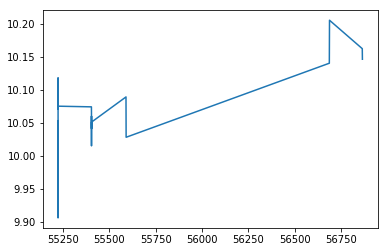

In [32]:
plt.plot(df['mjd'],df['w1mpro'])

In [33]:
foo = get_features(unique_names[0])

In [39]:
tmp = {col:np.nan for col in foo.columns}
tmp['Name'] = unique_names[0]
out = pd.DataFrame(data=np.array(tmp.values()).reshape(1,len(tmp.values())), 
                        columns=tmp.keys())
out

,Q31_color,KD_ymean_1,PercentAmplitude,MaxSlope,SmallKurtosis,Amplitude,KD_fit_sqresid,StetsonJ,Eta_color,Meanvariance,...,StructureFunction_index_21,Freq1_harmonics_rel_phase_1,CMD_r_squared,Freq1_harmonics_rel_phase_3,Beyond1Std,MedianAbsDev,SlottedA_length,FluxPercentileRatioMid80,PeriodLS,StetsonK_AC
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [40]:
foo

,Psi_eta,Q31_color,PercentAmplitude,MaxSlope,SmallKurtosis,KD_major_std_0,KD_theta_0,KD_fit_sqresid,StetsonJ,Eta_color,...,Freq1_harmonics_rel_phase_3,PairSlopeTrend,CAR_sigma,Autocor_length,StructureFunction_index_31,MedianAbsDev,Gskew,FluxPercentileRatioMid80,PeriodLS,StetsonK_AC
0,1.54289854922,0.0305,0.00983845499818,188.442212285,0.908494997573,0.0306179566274,0.687775688876,38.4187981263,0.282066295093,2300730864.55,...,-1.76808354802,-0.0333333333333,75.0947769478,1.0,2.01248687158,0.015,-0.0135,0.8125,30.1950443418,0.76675791443
